# Forecasting with a DNN

* [Google Colab Notebook](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


In [2]:
""" Define functions and constants to create synthetic Time Series data """
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [3]:
""" Create the Time Series and split it into training and validation sets """
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

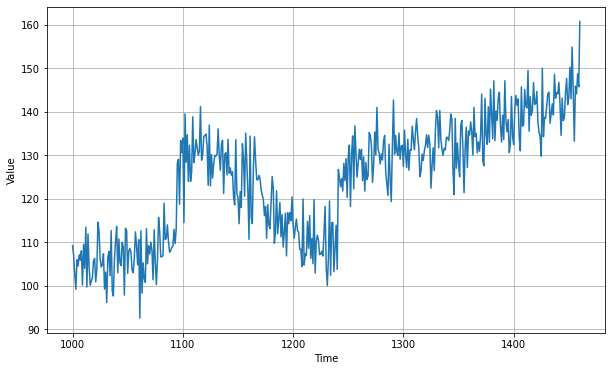

In [4]:
""" Define windowing constants and plot the validation series """
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [5]:
""" Create the windowed dataset """
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
""" Define, compile and fit the model """
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

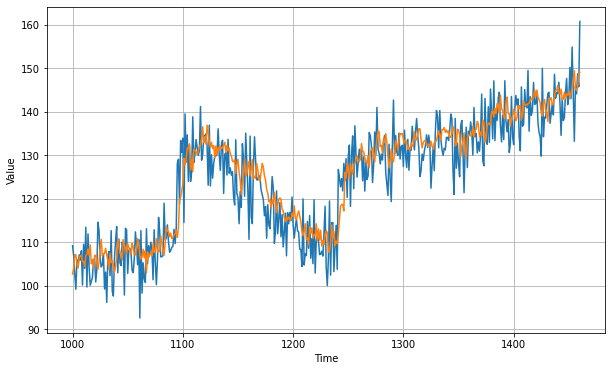

In [7]:
""" Forecast and chart the results against the validation series """
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
""" How's our MAE when using a "guessed" Learning Rate? """
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7763977

In [9]:
""" This time we'll use a callback to find the optimal Learning Rate """
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

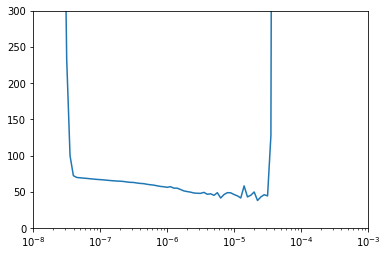

In [10]:
""" Plot the learning rates so we can manually inspect and choose the LR that has the lowest loss """
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [16]:
""" It's somewhere around 7e-6 or 8e-6, so let's retrain using this new Learning Rate """
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

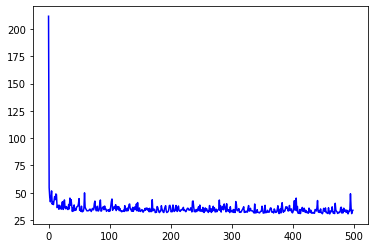

In [17]:
""" Now I'll plot the loss over the epochs to see how the training went """
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[46.49998474121094, 43.6953125, 48.93532180786133, 48.25532150268555, 36.40119934082031, 37.21694564819336, 38.62654113769531, 34.922096252441406, 38.533512115478516, 36.79428482055664, 35.597618103027344, 34.98347854614258, 40.93503189086914, 41.86149978637695, 34.762428283691406, 36.713348388671875, 43.470428466796875, 36.636940002441406, 35.44291305541992, 37.392520904541016, 36.69994354248047, 34.8672981262207, 34.699947357177734, 39.31182098388672, 35.28204345703125, 45.152225494384766, 38.74523162841797, 43.676048278808594, 38.395050048828125, 32.93281555175781, 36.203033447265625, 33.34056091308594, 38.86842346191406, 33.84843063354492, 35.04287338256836, 34.06966781616211, 36.8251838684082, 37.32140350341797, 37.65793228149414, 39.77236557006836, 44.66545486450195, 33.9412956237793, 34.59336853027344, 33.05613708496094, 37.741004943847656, 32.598289489746094, 32.813350677490234, 33.27481460571289, 35.83060836791992, 49.93400192260742, 36.775630950927734, 35.396278381347656, 34.

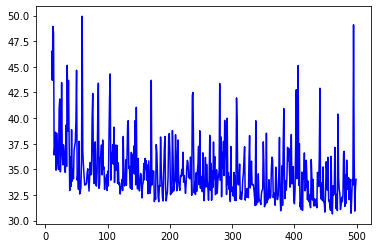

In [18]:
""" The first 10 are misleading, so let's plot all but the first 10 to get a better picture """
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

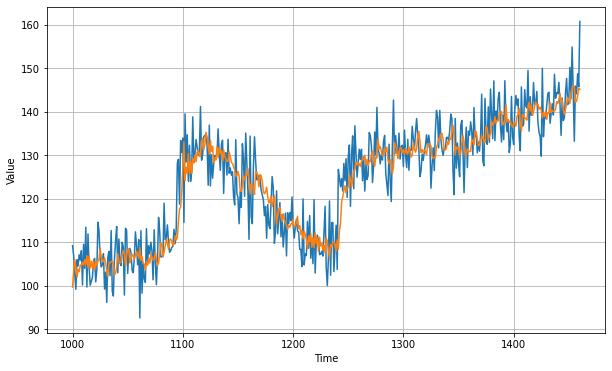

In [19]:
""" Forecast again using this new model """
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
""" How did the MAE for this model compare to the 4.7763977 of the first model?

* Model 1: lr=1e-6 => MAE of 4.7763977
* Model 2: lr=8e-6 => MAE of 6.087437
* Model 3: lr=7e-6 => MAE of 4.4991765
"""
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.4991765

## Observations

* I'm actually surprised how much worse `Model 2` did
* However, by changing the learning rate to `lr=7e-6`, we got the best results so far!